In [1]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566166 sha256=f9e817026c35c766eedabf9761baa36210dcc49ac5d06ff52919f233d376868d
  Stored in directory: /root/.cache/pip/wheels/04/52/ec/9355da79c29f160b038a20c784db2803c2f9fa2c8a462c176a
Successfully built face-recognition-models


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
import time
from tqdm import tqdm

In [4]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [5]:
import torch.nn as nn
from torchvision import models

class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim, dropout=0.3):
        super(AttentionLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.attention_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1, bias=False)
        )

    def forward(self, lstm_output):
        attention_scores = self.attention_net(lstm_output)
        attention_scores = torch.softmax(attention_scores, dim=1)
        attended_output = torch.sum(lstm_output * attention_scores, dim=1)
        return attended_output, attention_scores

class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained=True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional=bidirectional, dropout=0.3)
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.attention = AttentionLayer(lstm_output_dim, dropout=0.3)
        self.dp1 = nn.Dropout(0.5)
        self.dp2 = nn.Dropout(0.4)
        self.ln = nn.LayerNorm(lstm_output_dim)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_dim, lstm_output_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(lstm_output_dim // 2, num_classes)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, 2048)
        x = self.dp1(x)
        x_lstm, _ = self.lstm(x, None)
        attended_output, attention_weights = self.attention(x_lstm)
        attended_output = self.ln(attended_output)
        attended_output = self.dp2(attended_output)
        output = self.classifier(attended_output)
        return fmap, output

In [6]:
class validation_dataset(Dataset):
    def __init__(self, root_dir, transform=None, sequence_length=40):
        self.root_dir = root_dir
        self.sequence_length = sequence_length
        self.transform = transform

        self.video_paths = []
        self.labels = []

        # Supported video formats
        video_formats = ('.mp4', '.avi', '.mov', '.mkv', '.MP4', '.AVI', '.MOV', '.MKV')

        # Process real videos
        real_path = os.path.join(root_dir, 'real')
        real_videos = []
        if os.path.exists(real_path) and os.path.isdir(real_path):
            for root, _, files in os.walk(real_path):
                for video_file in files:
                    if video_file.endswith(video_formats):
                        full_path = os.path.join(root, video_file)
                        real_videos.append(full_path)
                        self.labels.append(1)  # Real label = 1
        else:
            print(f"Warning: Real video directory not found at {real_path}")

        # Process fake videos
        fake_path = os.path.join(root_dir, 'fake')
        fake_videos = []
        if os.path.exists(fake_path) and os.path.isdir(fake_path):
            for root, _, files in os.walk(fake_path):
                for video_file in files:
                    if video_file.endswith(video_formats):
                        full_path = os.path.join(root, video_file)
                        fake_videos.append(full_path)
                        self.labels.append(0)  # Fake label = 0
        else:
            print(f"Warning: Fake video directory not found at {fake_path}")

        # Combine all videos
        self.video_paths = real_videos + fake_videos
        num_real = len(real_videos)
        num_fake = len(fake_videos)

        print(f"Found {len(self.video_paths)} videos: {num_real} real, {num_fake} fake")
        print(f"First real video: {real_videos[0] if real_videos else 'None'}")
        print(f"First fake video: {fake_videos[0] if fake_videos else 'None'}")

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        frames = self.extract_frames(video_path)

        # Pad if we don't have enough frames
        if len(frames) < self.sequence_length:
            last_frame = frames[-1] if frames else torch.zeros(3, im_size, im_size)
            while len(frames) < self.sequence_length:
                frames.append(last_frame)

        # Convert list to tensor [seq_length, C, H, W]
        frames = torch.stack(frames)
        return frames, label, video_path  # Return video path for error tracking

    def extract_frames(self, video_path):
        vidObj = cv2.VideoCapture(video_path)
        frames = []
        total_frames = int(vidObj.get(cv2.CAP_PROP_FRAME_COUNT))
        a = max(1, int(total_frames / self.sequence_length))
        first_frame = np.random.randint(0, a) if a > 1 else 0

        count = 0
        success, image = vidObj.read()
        while success:
            if count % a == first_frame:
                try:
                    # Convert BGR to RGB
                    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    # Face detection and cropping
                    faces = face_recognition.face_locations(image_rgb)
                    if faces:
                        top, right, bottom, left = faces[0]
                        # Expand the face area slightly
                        margin = int((bottom - top) * 0.1)
                        top = max(0, top - margin)
                        bottom = min(image_rgb.shape[0], bottom + margin)
                        left = max(0, left - margin)
                        right = min(image_rgb.shape[1], right + margin)
                        image_cropped = image_rgb[top:bottom, left:right]
                    else:
                        image_cropped = image_rgb

                    # Apply transformations
                    if self.transform:
                        image_t = self.transform(image_cropped)
                        frames.append(image_t)
                except Exception as e:
                    print(f"\nError processing frame in {os.path.basename(video_path)}: {e}")

            if len(frames) >= self.sequence_length:
                break

            count += 1
            success, image = vidObj.read()

        vidObj.release()
        return frames

In [8]:
# Configuration
im_size = 112
sequence_length = 40
batch_size = 8
num_workers = 4  # For data loading

# Transformations
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Initialize dataset and dataloader
dataset_path = "/content/drive/MyDrive/celeb_DF"  # UPDATE THIS PATH
print(f"Loading dataset from: {dataset_path}")
dataset = validation_dataset(
    root_dir=dataset_path,
    transform=train_transforms,
    sequence_length=sequence_length
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)


Loading dataset from: /content/drive/MyDrive/celeb_DF
Found 1000 videos: 500 real, 500 fake
First real video: /content/drive/MyDrive/celeb_DF/real/engsjjoxfe.mp4
First fake video: /content/drive/MyDrive/celeb_DF/fake/achdeirhym.mp4


In [12]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = Model(num_classes=2).to(device)
model_path = '/content/drive/MyDrive/models/40_frames.pt'
print(f"Loading model from: {model_path}")
model.load_state_dict(torch.load(model_path))
model.eval()
print("Model loaded successfully")

# Evaluation
all_preds = []
all_labels = []
all_paths = []  # To track problematic videos
softmax = nn.Softmax(dim=1)

total_videos = len(dataset)
print(f"Starting evaluation of {total_videos} videos...")

# Create tqdm progress bar
progress_bar = tqdm(total=total_videos, desc="Evaluating Videos", unit="video")

start_time = time.time()
with torch.no_grad():
    for inputs, labels, paths in dataloader:
        try:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            _, outputs = model(inputs)
            probs = softmax(outputs)
            preds = torch.argmax(probs, dim=1)

            # Store results
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_paths.extend(paths)

            # Update progress bar
            progress_bar.update(len(inputs))

        except Exception as e:
            print(f"\nError processing batch: {e}")
            # Add placeholders for failed batch
            all_preds.extend([-1] * len(paths))
            all_labels.extend([-1] * len(paths))
            all_paths.extend(paths)
            progress_bar.update(len(inputs))

progress_bar.close()
elapsed_time = time.time() - start_time
print(f"\nEvaluation completed in {elapsed_time:.2f} seconds")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Loading model from: /content/drive/MyDrive/models/40_frames.pt
Model loaded successfully
Starting evaluation of 1000 videos...


Evaluating Videos:   0%|          | 0/1000 [00:00<?, ?video/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating Videos: 100%|██████████| 1000/1000 [06:09<00:00,  2.71video/s]


Evaluation completed in 369.03 seconds


In [15]:
# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=['Fake', 'Real'])

# Print results
print("\n" + "="*50)
print(f"Total Videos Evaluated: {total_videos}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print("="*50)


Total Videos Evaluated: 1000
Accuracy: 0.8930
F1 Score: 0.8905
Recall: 0.8700
Precision: 0.9119

Confusion Matrix:
[[458  42]
 [ 65 435]]

Classification Report:
              precision    recall  f1-score   support

        Fake       0.88      0.92      0.90       500
        Real       0.91      0.87      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



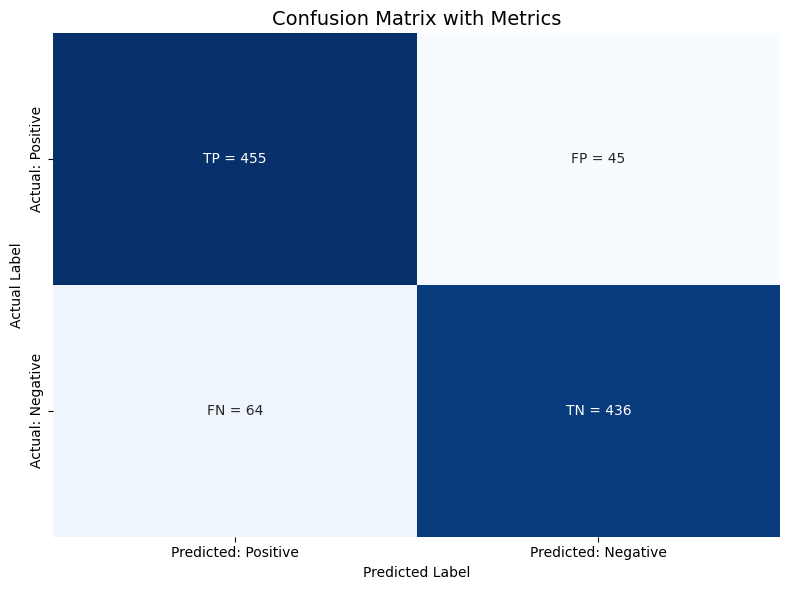

In [ ]:
import seaborn as sns
#Visulazing the confusion matrix

# Confusion matrix values
TP = 455
FP = 45
FN = 64
TN = 436


# Matrix and cell labels
matrix = np.array([[TP, FP],
                   [FN, TN]])

labels = np.array([
    [f"TP = {TP}", f"FP = {FP}"],
    [f"FN = {FN}", f"TN = {TN}"]
])


plt.figure(figsize=(8, 6))
ax = sns.heatmap(matrix, annot=labels, fmt="", cmap="Blues", cbar=False,
                 xticklabels=["Predicted: Positive", "Predicted: Negative"],
                 yticklabels=["Actual: Positive", "Actual: Negative"])

plt.title("Confusion Matrix with Metrics", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

plt.tight_layout()
plt.show()
